# NCA as brain : vizualizing information flow in NCA solving deep puzzles

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import mediapy
import optax
from cax.core.ca import CA
from cax.core.perceive.depthwise_conv_perceive import DepthwiseConvPerceive
from cax.core.perceive.kernels import grad_kernel, identity_kernel
from cax.core.state import state_to_alive, state_to_target
from cax.core.update.nca_update import NCAUpdate
from cax.nn.pool import Pool
from flax import nnx
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import wandb
import PIL

import augmax

In [2]:
%load_ext autoreload
%autoreload 2

## 1D-ARC Dataset

In [3]:
from simple_arc.data_processing import get_numpy_dataset, get_pandas_dataset

In [4]:
path = "../../1D-ARC/dataset/"
pd_dataset = get_pandas_dataset(path)

In [5]:
arc_dataset_1d = get_numpy_dataset(path)

In [67]:
def get_jax_data(path="../../1D-ARC/dataset/", tasks_used=None):
    arc_dataset_1d = get_numpy_dataset(path)

    arc_dataset_1d_jnp = {
        trial: {k: jnp.array(v) for k, v in trial_data.items() if v.dtype != np.object_}
        for trial, trial_data in arc_dataset_1d.items()
    }

    # Convert to jnp arrays

    image_train = arc_dataset_1d_jnp["train"]["input"].squeeze()
    image_test = arc_dataset_1d_jnp["test"]["input"].squeeze()

    target_train = arc_dataset_1d_jnp["train"]["output"].squeeze()
    target_test = arc_dataset_1d_jnp["test"]["output"].squeeze()

    n_objects = np.unique(target_train).shape[0]

    tasks_train = arc_dataset_1d_jnp["train"]["task_number"].squeeze()
    tasks_test = arc_dataset_1d_jnp["test"]["task_number"].squeeze()

    _, tasks_idxs = np.unique(arc_dataset_1d["train"]["tasks"], return_index=True)
    task_names = arc_dataset_1d["train"]["tasks"][sorted(tasks_idxs)]

    # One hot encoding into last channels

    image_train_oh, image_test_oh, target_train_oh, target_test_oh = [
        jax.nn.one_hot(x, n_objects)
        for x in [image_train, image_test, target_train, target_test]
    ]

    # Filter out object 0 (null object)
    image_train_oh, image_test_oh, target_train_oh, target_test_oh = [
        data.at[..., -n_objects].set(0)
        for data in [image_train_oh, image_test_oh, target_train_oh, target_test_oh]
    ]

    n_tasks_total = np.unique(tasks_test).shape[0]

    if tasks_used is not None:
        if isinstance(tasks_used, int):
            tasks_used = np.arange(tasks_used)
        elif isinstance(tasks_used, list):
            if isinstance(tasks_used[0], str):
                tasks_used = [task_names.tolist().index(task) for task in tasks_used]
            else:
                assert isinstance(tasks_used[0], int)
        else:
            raise ValueError("tasks_used should be an int or a list of int or str")

    # Filter out tasks
    tasks_idxs = {
        trial: {n: data == n for n in range(n_tasks_total)}
        for trial, data in zip(["train", "test"], [tasks_train, tasks_test])
    }

    [image_train, image_train_oh, target_train, target_train_oh, tasks_train], [
        image_test,
        image_test_oh,
        target_test,
        target_test_oh,
        tasks_test,
    ] = [
        [
            jnp.concatenate(
                [data[idx] for n, idx in tasks_idxs[trial].items() if n in tasks_used]
            )
            for data in datas
        ]
        for trial, datas in zip(
            ["train", "test"],
            [
                [
                    image_train,
                    image_train_oh,
                    target_train,
                    target_train_oh,
                    tasks_train,
                ],
                [
                    image_test,
                    image_test_oh,
                    target_test,
                    target_test_oh,
                    tasks_test,
                ],
            ],
        )
    ]
    
    # Renumber tasks        
    for n, v in enumerate(jnp.unique(tasks_train)):
        tasks_train = tasks_train.at[tasks_train == v].set(n)
    for n, v in enumerate(jnp.unique(tasks_test)):
        tasks_test = tasks_test.at[tasks_test == v].set(n)
    

    # Return data

    return {
        "train": [
            image_train,
            image_train_oh,
            target_train,
            target_train_oh,
            tasks_train,
        ],
        "test": [image_test, image_test_oh, target_test, target_test_oh, tasks_test],
        "task_names": task_names,
        "n_objects": n_objects,
        "tasks_used": tasks_used,
    }

In [68]:
tasks_used = ["1d_move_1p"]
jax_1d_arc_data = get_jax_data(path=path, tasks_used=tasks_used)

In [69]:
image_train_og, image_train, target_train_og, target_train, tasks_train = (
    jax_1d_arc_data["train"]
)
image_test_og, image_test, target_test_og, target_test, tasks_test = jax_1d_arc_data[
    "test"
]
n_channel_target = target_train.shape[-1]

In [70]:
np.unique(tasks_train, return_counts=True)

(array([0], dtype=int32), array([150]))

In [71]:
seed = 42

pool_size = 1_024
batch_size = 8
replace_size = 1
num_steps = 64
learning_rate = 1e-3

task_in_context = False
input_in_context = True

channel_size = 32
num_kernels = 3
hidden_size = 256
cell_dropout_rate = 0.5
update_weight_scale = 1.0

task_context_size = (
    len(tasks_used) if isinstance(tasks_used, list) else tasks_used
)
input_context_size = n_channel_target

context_size = task_context_size * task_in_context + input_context_size * input_in_context

spatial_dim = image_train.shape[1]

key = jax.random.PRNGKey(seed)
rngs = nnx.Rngs(seed)

depth = 16

alpha = 0.
background = 1e-3
alive_threshold = -jnp.inf
# alive_threshold = 0.0

config = {
    "seed": seed,
    "pool_size": pool_size,
    "batch_size": batch_size,
    "replace_size": replace_size,
    "num_steps": num_steps,
    "learning_rate": learning_rate,
    "task_in_context": task_in_context,
    "channel_size": channel_size,
    "num_kernels": num_kernels,
    "hidden_size": hidden_size,
    "cell_dropout_rate": cell_dropout_rate,
    "depth": depth,
    "alpha": alpha,
    "background": background,
    "type": "1D-ARC",
}

In [72]:
def init_state(key, ca=None, trial="train"):

    key, input_key = jax.random.split(key, 2)

    state_shape = image_train.shape[1:2] + (depth,) + (channel_size,)
    state = jnp.zeros(state_shape)

    input_index = jax.random.choice(
        input_key,
        image_train.shape[0],
        shape=(),
        replace=False,
    )

    if trial == "train":
        target = target_train[input_index]
        input_images = image_train[input_index]
        task = tasks_train[input_index]
    else:
        target = target_test[input_index]
        input_images = image_test[input_index]
        task = tasks_test[input_index]

    # Set the "alive" cells
    state = state.at[(slice(spatial_dim),) + (0,) + (channel_size - 1,)].set((input_images[..., 1:].sum(-1) > 0))

    # mask = mask.at[slice(spatial_dim) + (0,) + (-1,)].set((input_images[..., 1:].sum(-1) > 0))
    # mask = jnp.broadcast_to((input_images[..., 1:].sum(-1) > 0)[:, None, None], state.shape)
    # state = jnp.where(mask, 1.0, 0.0)

    target_state = jnp.zeros_like(state)
    target_state = target_state.at[
        (slice(spatial_dim),)
        + (depth - 1,)
        + (slice(channel_size - n_channel_target, channel_size),)
    ].set(target)
    
    print(task)

    context = jnp.zeros((spatial_dim, depth, context_size))
    task_context = jax.nn.one_hot(task, task_context_size)
    c_size = 0
    if task_in_context:
        context = context.at[
            (slice(spatial_dim),)
            + (0,)
            + (slice(context_size - c_size - task_context_size, context_size - c_size),)
        ].set(task_context)
        c_size += task_context_size
    
    if input_in_context:
        context = context.at[
            (slice(spatial_dim),)
            + (0,)
            + (slice(context_size - c_size - n_channel_target, context_size - c_size),)
        ].set(input_images)
        c_size += n_channel_target

    assert c_size == context.shape[-1] == context_size, "Context size mismatch"

    return {
        "state": state,
        "target": target,
        "target_state": target_state,
        "task": task,
        "input_index": input_index,
        "input_images": input_images,
        "context": context,
    }

In [73]:
subkeys = jax.random.split(key, 8)
new_data = jax.vmap(lambda key: init_state(key))(subkeys)

Traced<ShapedArray(int32[])>with<BatchTrace(level=1/0)> with
  val = Array([0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)
  batch_dim = 0


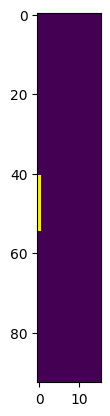

In [76]:
plt.imshow(new_data["context"][0, :, :, :].sum(-1))

In [77]:
new_data["context"].shape

(8, 93, 16, 10)

In [78]:
new_data["context"].any()

Array(True, dtype=bool)

## Model

In [79]:
from cax.types import Input, State
from functools import partial


class InputFeedCA(CA):

    def __init__(self, perceive, update):
        super().__init__(perceive, update)

    @nnx.jit
    def step(self, state, context_input):

        context, input = context_input

        state = state.at[
            (slice(spatial_dim),)
            + (0,)
            + (slice(channel_size - n_channel_target -1 , channel_size -1),)
        ].set(input)

        perception = self.perceive(state)
        state = self.update(state, perception, context)

        return state

    @partial(nnx.jit, static_argnames=("num_steps", "all_steps", "input_in_axis"))
    def __call__(
        self,
        first_state: State,
        context: Input,
        input: Input | None = None,
        *,
        num_steps: int = 1,
        all_steps: bool = False,
        input_in_axis: int | None = None,
    ) -> State:
        """Run the CA for multiple steps.

        Args:
                state: Initial state.
                input: Optional input.
                num_steps: Number of steps to run.
                all_steps: Whether to return all intermediate states.
                input_in_axis: Axis for input if provided for each step.

        Returns:
                Final state or all intermediate states if all_steps is True.

        """

        def step(
            carry: tuple[CA, State], context_input: tuple[Input, Input] | None
        ) -> tuple[tuple[CA, State], State]:
            ca, state = carry
            state = ca.step(state, context_input)
            return (ca, state), state if all_steps else None  # type: ignore

        (_, last_state), states = nnx.scan(
            step,
            in_axes=(nnx.Carry, input_in_axis),
            length=num_steps,
        )((self, first_state), (context, input))

        return (
            jnp.concatenate([first_state[None, ...], states], axis=0)
            if all_steps
            else last_state
        )

In [80]:
def get_model():
    perceive = DepthwiseConvPerceive(channel_size, rngs)
    update = NCAUpdate(
        channel_size,
        context_size + num_kernels * channel_size,
        (hidden_size,),
        rngs,
        cell_dropout_rate=cell_dropout_rate,
        alive_threshold=alive_threshold,
        init_do_nothing=False,
        activation_fn=nnx.tanh,
        use_bias=False,
    )

    kernel = jnp.concatenate([identity_kernel(ndim=2), grad_kernel(ndim=2)], axis=-1)
    kernel = jnp.expand_dims(jnp.concatenate([kernel] * channel_size, axis=-1), axis=-2)
    perceive.depthwise_conv.kernel = nnx.Param(kernel)
    ca = CA(perceive, update)
    params = nnx.state(ca, nnx.Param)
    print(
        "Number of params:",
        jax.tree_util.tree_reduce(lambda x, y: x + y.size, params, 0),
    )
    return ca

In [81]:
def get_pool(key, ca=None):

    key, subkey = jax.random.split(key)

    keys = jax.random.split(subkey, pool_size)
    new_data = jax.vmap(
        lambda key: init_state(
            key,
            ca,
        )
    )(keys)

    pool = Pool.create(new_data)
    return pool

### Optimizer

In [82]:
def get_optimizer(ca):
    lr_sched = optax.linear_schedule(
        init_value=learning_rate,
        end_value=0.1 * learning_rate,
        transition_steps=50_000,
    )
    optimizer = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adam(learning_rate=lr_sched),
    )
    grad_params = nnx.All(
        nnx.Param, nnx.Any(nnx.PathContains("update"), nnx.PathContains("encoder"))
    )
    optimizer = nnx.Optimizer(ca, optimizer, wrt=grad_params)
    return optimizer, grad_params

## Train

### Loss

In [83]:
# def mse(state, target):
#     if len(state.shape) != len(target.shape):
#         loss = jax.vmap(lambda t: mse(state, t))(
#             target.swapaxes(0, 1) if state.shape[0] == target.shape[0] else target
#         )
#     else:
#         loss = jnp.square(state_to_alive(state) - target)

#     return loss


def mse(state, target):
    return jnp.square(state - target)


@nnx.jit
def loss_fn(ca, state, target, context, key):

    key, randint_key = jax.random.split(key, 2)

    print(state.shape, context.shape)
    state = nnx.vmap(
        lambda state, context: ca(
            state, context, num_steps=num_steps, all_steps=True
        )
    )(state, context)

    index = jax.random.randint(
        randint_key, (state.shape[0],), num_steps // 2, num_steps
    )
    state = state[jnp.arange(state.shape[0]), index]

    # loss = mse(
    #     state_to_target(state, n_channel_target)[..., -1, :],
    #     state_to_target(target, n_channel_target)[..., -1, :],
    # )

    loss = optax.softmax_cross_entropy_with_integer_labels(
        state_to_target(state, n_channel_target)[..., -1, :],
        state_to_target(target, n_channel_target)[..., -1, :].argmax(-1),
    )

    # Regularization to avoid dead cells
    loss += alpha * jnp.mean(jnp.square(state[..., 1:-1, -1] - background))
    # loss += alpha * jnp.exp(-jnp.mean(jnp.square(state[..., 1:-1, :])))
    # loss += alpha * jnp.exp(jnp.mean(jnp.square(state - background)))

    return loss.mean(), (state, loss)

### Train Step

In [84]:
@nnx.jit
def train_step(ca, optimizer, pool, key, batch_size=batch_size):

    sample_key, init_state_key, loss_key = jax.random.split(key, 3)

    # Sample from pool
    pool_index, sample = pool.sample(sample_key, batch_size=batch_size)

    current_data = {k: sample[k] for k in sample.keys()}
    current_target = current_data["target_state"]

    # Sort by descending loss
    sort_index = jnp.argsort(
        jax.vmap(lambda state, target: mse(state, target).mean())(
            current_data["state"], current_target
        ),
        descending=True,
    )
    pool_index = pool_index[sort_index]
    # current_data = {k: current_data[k][sort_index] for k in current_data.keys()}
    current_data = jax.tree.map(lambda x: x[sort_index], current_data)

    r_size = min(replace_size, batch_size)
    init_state_keys = jax.random.split(init_state_key, r_size)
    # Sample a new target to replace the worst
    new_data = jax.vmap(lambda key: init_state(key, ca))(init_state_keys)

    # for k in current_data.keys():
    #     current_data[k] = current_data[k].at[:r_size].set(new_data[k])

    # Update the worst performing samples with new data
    current_data = jax.tree.map(
        lambda cur, new: cur.at[:r_size].set(new), current_data, new_data
    )

    (loss, (current_state, complete_loss)), grad = nnx.value_and_grad(
        loss_fn,
        has_aux=True,
        argnums=nnx.DiffState(0, grad_params),
    )(
        ca,
        current_data["state"],
        current_data["target_state"],
        current_data["context"],
        loss_key,
    )

    current_data["state"] = current_state

    optimizer.update(grad)
    pool = pool.update(pool_index, current_data)

    return loss, pool, grad, current_data["context"], complete_loss

## Main Loop

In [85]:
def vizualize(ca, key, plot=True, n_samples=8, trial="train", **plot_kwargs):

    keys = jax.random.split(key, n_samples)
    new_data = jax.vmap(lambda key: init_state(key, trial=trial))(keys)

    

    state = nnx.vmap(
        lambda state, context: ca(
            state, context, num_steps=num_steps, all_steps=True
        )
    )(new_data["state"], new_data["context"])
    # assert (state == new_data["state"]).all(), "First state should not be updated"

    initial_state = state[:, 0, :, :, -n_channel_target:].argmax(-1) / 10
    final_state = state[:, -1, :, :, -n_channel_target:].argmax(-1) / 10
    target_state = new_data["target_state"][..., -n_channel_target:].argmax(-1) / 10
    state_trajectories = jnp.squeeze(
        state_to_target(state.swapaxes(-2, -3), n_channel_target).argmax(-1) / 10
    )

    if plot:

        mediapy.set_show_save_dir(None)
        mediapy.show_images(
            initial_state.swapaxes(-1, -2),
            width=128 * 2,
            height=128,
            **plot_kwargs,
            titles=["Initial state"] * n_samples,
        )

        mediapy.show_images(
            target_state.swapaxes(-1, -2),
            width=128 * 2,
            height=128,
            **plot_kwargs,
            titles=["Target state"] * n_samples,
        )

        mediapy.show_images(
            final_state.swapaxes(-1, -2),
            width=128 * 2,
            height=128,
            **plot_kwargs,
            titles=["Final state"] * n_samples,
        )

        mediapy.set_show_save_dir("/WIP/gifs/")
        mediapy.show_videos(
            state_trajectories,
            width=128,
            height=128,
            codec="gif",
            **plot_kwargs,
        )

    return (initial_state, final_state, state_trajectories, new_data, state)


class Trainer:
    def __init__(self, key, pool, ca, optimizer):
        self.key = key
        self.pool = pool
        self.ca = ca
        self.optimizer = optimizer
        self.run = None

    def train(self, n_steps, retain_grads=False, use_wandb=False):
        pbar = tqdm(range(n_steps))
        self.losses = [] if not hasattr(self, "losses") else self.losses
        self.grads = []

        if self.run is None and use_wandb:
            self.run = wandb.init(project="NCA", entity="gbena", config=config)

        for i in pbar:
            self.key, subkey = jax.random.split(self.key)
            loss, pool, grad, context, complete_loss = train_step(
                self.ca, self.optimizer, self.pool, subkey
            )
            # pbar.set_postfix(loss=loss)
            # Calculate smooth slope of the loss to gauge variations
            window_size = n_steps // 100
            self.losses.append(loss.mean())
            if retain_grads:
                self.grads.append(grad)

            pbar.set_postfix(loss=np.format_float_scientific(loss.mean(), 3))

            if use_wandb and i >= 10:
                print("Logging to wandb")
                self.wandb_log(loss, i)

        return self.losses, pool

    def wandb_log(self, loss, i):

        logs = {"train_loss": loss.mean(), "step": i}

        if i % 1000 == 10:
            initial_states, final_states, _, all_states = vizualize(
                self.ca, jax.random.PRNGKey(43), plot=False
            )
            initial_states, final_states = [
                [
                    PIL.Image.fromarray(image).convert("RGB")
                    for image in np.array(images) * 255
                ]
                for images in [initial_states, final_states]
            ]

            logs.update(
                {
                    "final_states": [wandb.Image(image) for image in final_states],
                    "initial_states": [wandb.Image(image) for image in initial_states],
                    "states": [
                        wandb.Video(image)
                        for image in np.array(all_states)
                        .swapaxes(-1, 1)
                        .swapaxes(-1, -2)[:, -3:]
                        * 255
                    ],
                }
            )

        wandb.log(logs)

    def plot_loss(self):
        v = len(self.losses) // 10
        plt.plot(jnp.convolve(jnp.array(self.losses), jnp.ones(v) / v, mode="valid"))
        plt.yscale("log")
        plt.show()

In [86]:
key, subkey = jax.random.split(key, 2)
subkeys = jax.random.split(subkey, pool_size)
new_data = jax.vmap(lambda key: init_state(key, trial="train"))(subkeys)

Traced<ShapedArray(int32[])>with<BatchTrace(level=1/0)> with
  val = Array([0, 0, 0, ..., 0, 0, 0], dtype=int32)
  batch_dim = 0


In [87]:
ca = get_model()
optimizer, grad_params = get_optimizer(ca)
pool = get_pool(key)

trainer = Trainer(key, pool, ca, optimizer)

Number of params: 36192
Traced<ShapedArray(int32[])>with<BatchTrace(level=1/0)> with
  val = Array([0, 0, 0, ..., 0, 0, 0], dtype=int32)
  batch_dim = 0


In [88]:
# losses, pool = trainer.train(2**4, retain_grads=True)

In [89]:
if hasattr(trainer, "grads"):
    print(trainer.grads[-1]["update"]["layers"][1]["kernel"].value.any())

In [90]:
first_states, last_states, _, new_data, all_state = vizualize(
    ca, jax.random.PRNGKey(43), plot=True
)

Traced<ShapedArray(int32[])>with<BatchTrace(level=1/0)> with
  val = Array([0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)
  batch_dim = 0


Initial state,Initial state,Initial state,Initial state,Initial state,Initial state,Initial state,Initial state


Target state,Target state,Target state,Target state,Target state,Target state,Target state,Target state


Final state,Final state,Final state,Final state,Final state,Final state,Final state,Final state


,,,,,,,


In [46]:
new_state = ca.step(new_data["state"][0], new_data["context"][0])

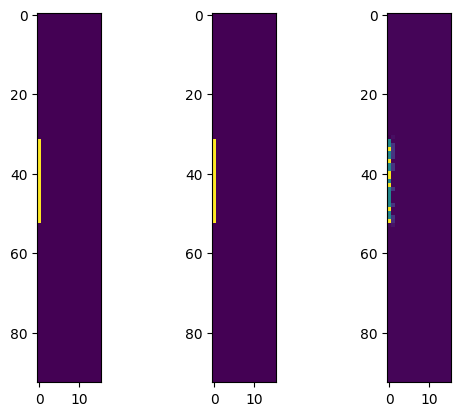

In [91]:
fig, axs = plt.subplots(1, 3)
axs[2].imshow(new_state.sum(-1), vmin=None)
axs[0].imshow(new_data["state"][0].sum(-1), vmin=None)
axs[1].imshow(new_data["context"][0].sum(-1), vmin=None)

In [ ]:
raise KeyboardInterrupt

KeyboardInterrupt: 

In [104]:
losses, pool = trainer.train(2**14, use_wandb=False)

  0%|          | 0/16384 [00:00<?, ?it/s]

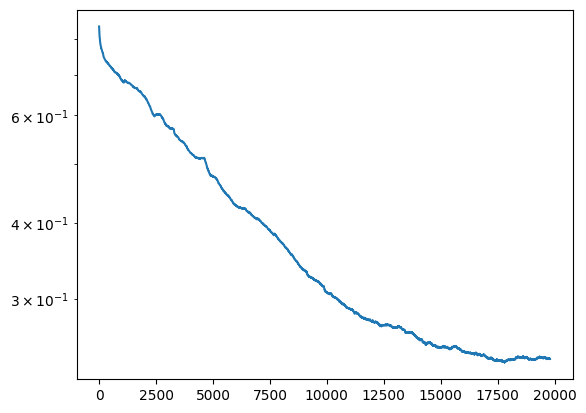

In [102]:
trainer.plot_loss()

In [103]:
initial_states, final_states, _, new_data, all_states = vizualize(
    ca, jax.random.PRNGKey(42), plot=True, trial="train"
)

Traced<ShapedArray(int32[])>with<BatchTrace(level=1/0)> with
  val = Array([0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)
  batch_dim = 0


Initial state,Initial state,Initial state,Initial state,Initial state,Initial state,Initial state,Initial state


Target state,Target state,Target state,Target state,Target state,Target state,Target state,Target state


Final state,Final state,Final state,Final state,Final state,Final state,Final state,Final state


,,,,,,,


In [ ]:
# save as pickle
import pickle

pickle.dump(nnx.state(ca, nnx.Param), open("1d_arc.pkl", "wb"))